<a href="https://colab.research.google.com/github/kozen88/HCV_DM23/blob/main/Addestramento_modelli_di_esemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Addestramento con esemble medols

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sb
sb.set()

In [3]:
df = pd.read_csv('HCV_ImputerMean.csv', delimiter=',')
print(df)

      Age   Gender   BMI  Fever  Nausea/Vomting  Headache   Diarrhea   \
0     56.0     1.0  35.0    2.0             1.0        1.0        1.0   
1     46.0     1.0  29.0    1.0             2.0        2.0        1.0   
2     57.0     1.0  33.0    2.0             2.0        2.0        2.0   
3     49.0     2.0  33.0    1.0             2.0        1.0        2.0   
4     59.0     1.0  32.0    1.0             1.0        2.0        1.0   
...    ...     ...   ...    ...             ...        ...        ...   
1380  44.0     1.0  29.0    1.0             2.0        2.0        2.0   
1381  55.0     1.0  34.0    1.0             2.0        2.0        1.0   
1382  42.0     1.0  26.0    2.0             2.0        1.0        1.0   
1383  52.0     1.0  29.0    2.0             1.0        1.0        2.0   
1384  55.0     2.0  26.0    1.0             2.0        2.0        2.0   

      Fatigue & generalized bone ache   Jaundice   Epigastric pain   ...  \
0                                  2.0        2

In [ ]:
df_reduced = pd.read_csv('pca_reduced_df_uncleaned.csv', delimiter=',')
print(df_reduced)

### Metodi di esemble che sfruttano il Bagging

Procediamo all'addestramento di alcuni modelli di ensemble e iniziamo ad addestrare il più comune e utilizzato nella letteratura scientifica ovvero una random forest.

Una random forest è un modello di esemble che si base sulla tecnica del Bootstrap aggregating, conosciuto anche semplicemente come Bagging, implica che in questo insieme di algoritmi ognuno conti allo stesso modo e abbia quindi lo stesso peso.

Ogni singolo classificatore di addestra su una porzione casuale di dati, questo riesce a limitare l’overfitting e aumentare le sue capacità predittive. In questa aggregazione di modelli, viene utilizzata una tecnica chiamata boostrap: alcuni dati possono comparire contemporaneamente in più modelli mentre altri potrebbero non comparire mai. Questa tecnica si chiama anche campionamento causale con rimpiazzo.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

# effettuiamo la divisione tra feature di input e feature target
X = df.drop('Baselinehistological staging', axis=1)
y = df['Baselinehistological staging']

# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Istanziazione di un modello random forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# usiamo la cross-val
scores = cross_val_score(clf, X, y, cv=10)
mean_accurancy = scores.mean()
print("Accurancy su ogni ciclo della cross-validation:\n", scores)
print("Accurancy mediata su i 10 fold fatti:", mean_accurancy)


Accurancy su ogni ciclo della cross-validation:
 [0.25179856 0.22302158 0.25179856 0.21582734 0.29496403 0.20289855
 0.23913043 0.20289855 0.27536232 0.20289855]
Accurancy mediata su i 10 fold fatti: 0.23605984777395475


Andiamo a creare delle funzioni per effettuare un analisi completa delle performance del classificatore.

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_curve, fbeta_score, confusion_matrix
from sklearn.model_selection import cross_val_predict

# funzione per il calcolo di una batterie di metriche di valutazione
def full_evaluate_multiclass(classifier, X, y):
    """
    Esegue una cross-validation con 10 fold per un classificatore multi-classe e calcola le metriche di valutazione.

    Parameters:
    classifier: Classificatore multi-classe.
    X (array-like): Matrice di dati di input.
    y (array-like): Vettore di etichette di output.

    Returns:
    None.
    """
    # Esegue la cross-validation con 10 fold
    scores = cross_val_score(classifier, X, y, cv=10)

    # Calcola le metriche di valutazione
    y_pred = cross_val_predict(classifier, X, y, cv=10)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    precision_macro = precision_score(y, y_pred, average='macro')
    precision_micro = precision_score(y, y_pred, average='micro')
    recall_macro = recall_score(y, y_pred, average='macro')
    recall_micro = recall_score(y, y_pred, average='micro')
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    f2_micro = fbeta_score(y, y_pred, beta=2, average='micro')
    f2_macro = fbeta_score(y, y_pred, beta=2, average='macro')
    f2_weighted = fbeta_score(y, y_pred, beta=2, average='weighted')
    conf_matrix = confusion_matrix(y, y_pred)

    # Stampa le metriche di valutazione
    print("Accuracy:", scores.mean())
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1-score (Macro):", f1_macro)
    print("F1-score (Micro):", f1_micro)
    print("F2-score (Micro):", f2_micro)
    print("F2-score (Macro):", f2_macro)
    print("F2-score (Weighted):", f2_weighted)
    print("Confusion matrix:\n", conf_matrix)

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# funzione per il calcolo della Roc_AUC_score
def evaluate_roc_auc(classifier, X, y):
    """
    Calcola la metrica roc_auc_score e plotta la curva ROC multi-classe per un classificatore multi-classe.

    Parameters:
    classifier: Classificatore multi-classe.
    X (array-like): Matrice di dati di input.
    y (array-like): Vettore di etichette di output.

    Returns:
    None.
    """
    # Esegue la cross-validation con 10 fold
    y_pred = cross_val_predict(classifier, X, y, cv=10, method='predict_proba')

    # Calcola la metrica roc_auc_score
    y_bin = label_binarize(y, classes=np.unique(y))
    roc_auc_score_macro = roc_auc_score(y_bin, y_pred, average='macro')

    # Calcola la curva ROC multi-classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_bin.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcola la media delle aree sotto la curva ROC per ogni classe
    roc_auc_score_micro = np.mean(list(roc_auc.values()))

    # Plotta la curva ROC multi-classe
    plt.figure()
    lw = 2
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Stampa la metrica roc_auc_score
    print("ROC AUC Score (macro):", roc_auc_score_macro)
    print("ROC AUC Score (micro):", roc_auc_score_micro)


In [7]:
# Istanziazione di un modello random forest
clf_RFt = RandomForestClassifier(n_estimators=100, random_state=42)

# andiamo a visualizzare un quadro delle metriche completo
full_evaluate_multiclass(clf_RFt, X, y)

Accuracy: 0.23605984777395475
Precision: 0.23447150758488386
Recall: 0.23610108303249097
F1-score: 0.23460541921188974
Precision (Macro): 0.23410495493873829
Precision (Micro): 0.23610108303249097
Recall (Macro): 0.2349463732236995
Recall (Micro): 0.23610108303249097
F1-score (Macro): 0.23384225761067245
F1-score (Micro): 0.23610108303249097
F2-score (Micro): 0.23610108303249094
F2-score (Macro): 0.23434696652747186
F2-score (Weighted): 0.23534513458408635
Confusion matrix:
 [[ 57  72 104 103]
 [ 66  77 104  85]
 [ 85  71  93 106]
 [ 74  95  93 100]]


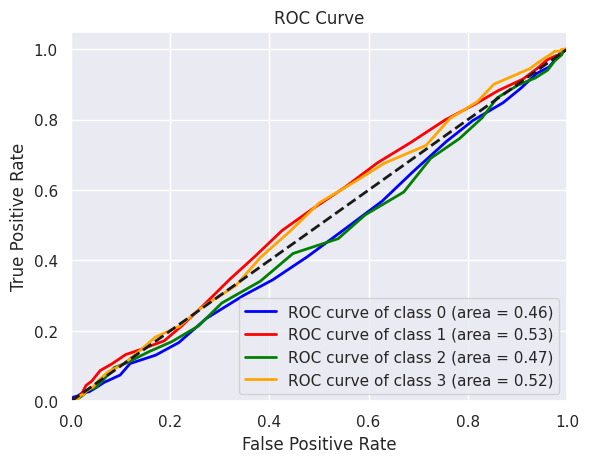

ROC AUC Score (macro): 0.4962342361685489
ROC AUC Score (micro): 0.4962342361685489


In [8]:
# Istanziazione di un modello random forest
clf_RFt2 = RandomForestClassifier(n_estimators=100, random_state=42)

# plotta la curva del roc_auc_score
evaluate_roc_auc(clf_RFt2, X, y)

In [ ]:
# creiamo questa funzione di addestramento per automatizzare i nostri esperimenti
def evaluate_classifiers(cv_values, classifiers, X, y):
    for classifier in classifiers:
        print("Classifier:", classifier)
        for cv in cv_values:
            model = classifier()
            scores = cross_val_score(model, X, y, cv=cv)
            mean_accuracy = scores.mean()
            print("CV:", cv)
            print("Mean Accuracy:", mean_accuracy)
            print("Scores:", scores)
            print("__________________________________________________________________________")
            print("##########################################################################")
            print(" ")

In [ ]:
values = [5, 10, 15, 20]
classifier_model = [RandomForestClassifier]

evaluate_classifiers(values, classifier_model, X, y)

Classifier: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV: 5
Mean Accuracy: 0.2512635379061372
Scores: [0.24548736 0.27075812 0.25631769 0.23465704 0.24909747]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.2498696694818059
Scores: [0.17266187 0.30215827 0.20143885 0.20143885 0.30215827 0.23913043
 0.19565217 0.25362319 0.32608696 0.30434783]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.24114071996259934
Scores: [0.29032258 0.20430108 0.29032258 0.27956989 0.16129032 0.22826087
 0.27173913 0.16304348 0.22826087 0.25       0.23913043 0.19565217
 0.22826087 0.31521739 0.27173913]
__________________________________________________________________________
#################################################################

In [ ]:
def evaluate_classifiers_with_plot(cv_values, classifiers, X, y, step):
    for classifier in classifiers:
        print("Classifier:", classifier)
        mean_accuracies_list = []
        for cv in cv_values:
            model = classifier()
            scores = cross_val_score(model, X, y, cv=cv)
            mean_accuracy = scores.mean()
            mean_accuracies_list.append(mean_accuracy)
            print("CV:", cv)
            print("Mean Accuracy:", mean_accuracy)
            print("Scores:", scores)
            print("__________________________________________________________________________")
            print("##########################################################################")
            print(" ")

        # Plotting the mean accuracies
        cv_range = np.array(cv_values)
        plt.plot(cv_range, mean_accuracies_list)
        plt.xticks(np.arange(0, max(cv_range) + 1, step))
        plt.xlabel('Number of folds (cv)')
        plt.ylabel('Mean Accuracy')
        plt.title('Cross-Validation Mean Accuracy')
        plt.show()

Classifier: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV: 2
Mean Accuracy: 0.24621003594992036
Scores: [0.24531025 0.24710983]
____________________________________________________________
############################################################
 
CV: 3
Mean Accuracy: 0.2281695166727705
Scores: [0.20995671 0.23160173 0.24295011]
____________________________________________________________
############################################################
 
CV: 4
Mean Accuracy: 0.2592202362112908
Scores: [0.23919308 0.26589595 0.24566474 0.28612717]
____________________________________________________________
############################################################
 
CV: 5
Mean Accuracy: 0.25342960288808664
Scores: [0.2599278  0.27797834 0.22743682 0.24909747 0.25270758]
____________________________________________________________
############################################################
 
CV: 6
Mean Accuracy: 0.2599347512390991
Scores: [0.22943723 0.25974026 0.26406

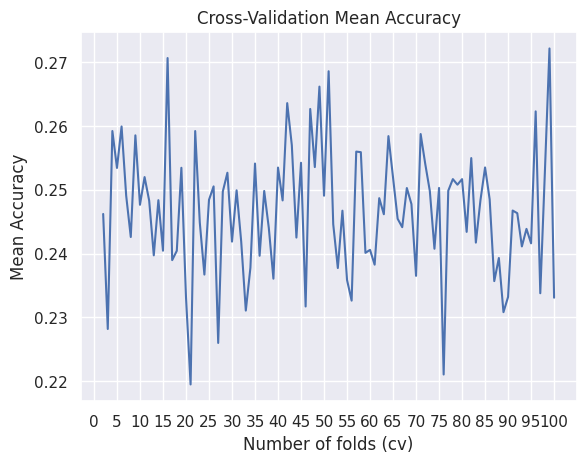

In [ ]:
# con questo codice andiamo a cercare di ottimizzare la cross-validation
list_cv = range(2,101) # questo esperimento è stato condotto con 30, 100, 300 fold che sono stati documentati
evaluate_classifiers_with_plot(list_cv, classifier_model, X, y, 5)

#### Conclusioni sul random forest
Non sembrano esserci grossi cambiamenti quello che notiamo perà e che il random forest tende ad essere più stabile degli alberi e si stabilizza maggiormente nell'intervallo che oscilla tra una accurancy di [24,26].

Ora proviamo ancora un altro modello di ensemble learning basato sugli alberi decisionali e in particolare che utilizza ancora la tecnica del Bagging ovvero Bootstrap aggregating.

In [9]:
from sklearn.ensemble import ExtraTreesClassifier

# istanzia un modello di classificatore Extra Trees
clf_ExT = ExtraTreesClassifier()

# usiamo la cross-val
scores_ExT = cross_val_score(clf_ExT, X, y, cv=10)
mean_accurancy_ExT = scores_ExT.mean()
print("Accurancy su ogni ciclo della cross-validation:\n", scores_ExT)
print("Accurancy mediata su i 10 fold fatti:", mean_accurancy_ExT)

Accurancy su ogni ciclo della cross-validation:
 [0.21582734 0.17985612 0.24460432 0.28057554 0.28057554 0.19565217
 0.26811594 0.26086957 0.26811594 0.29710145]
Accurancy mediata su i 10 fold fatti: 0.24912939213846313


In [10]:
# Istanziazione di un modello extra tree
clf_ETe = ExtraTreesClassifier()

# andiamo a visualizzare un quadro delle metriche completo
full_evaluate_multiclass(clf_ETe, X, y)

Accuracy: 0.25194974455218433
Precision: 0.23632493304381172
Recall: 0.2375451263537906
F1-score: 0.23663401715192708
Precision (Macro): 0.23566893049068616
Precision (Micro): 0.2375451263537906
Recall (Macro): 0.23626312320996024
Recall (Micro): 0.2375451263537906
F1-score (Macro): 0.23566512732540246
F1-score (Micro): 0.2375451263537906
F2-score (Micro): 0.2375451263537906
F2-score (Macro): 0.23595195527519636
F2-score (Weighted): 0.23710850591351854
Confusion matrix:
 [[ 59  75 107  95]
 [ 75  76  88  93]
 [103  72  85  95]
 [ 80  81  92 109]]


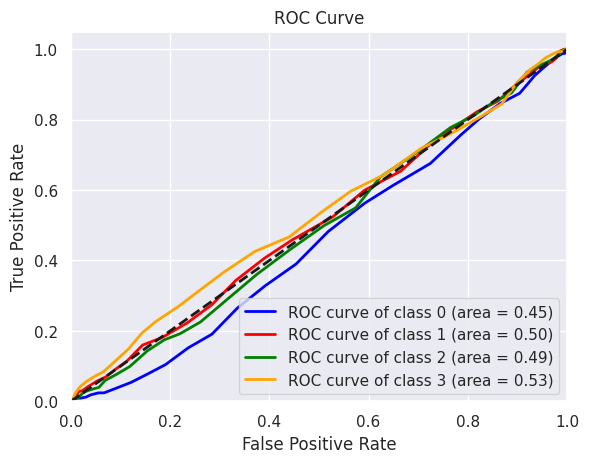

ROC AUC Score (macro): 0.49328749608172895
ROC AUC Score (micro): 0.49328749608172895


In [11]:
# Istanziazione di un modello extra tree
clf_ETe2 = ExtraTreesClassifier()

# plotta la curva del roc_auc_score
evaluate_roc_auc(clf_ETe2 , X, y)

In [ ]:
# Andiamo a testaare il modello di Extra trees sui principali valori di cross_val
clf_ET = [ExtraTreesClassifier]
evaluate_classifiers(values, clf_ET, X, y)

Classifier: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
CV: 5
Mean Accuracy: 0.25198555956678703
Scores: [0.2166065  0.25270758 0.27436823 0.2599278  0.25631769]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.25489000104264414
Scores: [0.21582734 0.23021583 0.28057554 0.28057554 0.24460432 0.26811594
 0.23913043 0.26086957 0.30434783 0.22463768]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.2555867227676485
Scores: [0.27956989 0.17204301 0.25806452 0.34408602 0.23655914 0.27173913
 0.27173913 0.32608696 0.16304348 0.29347826 0.29347826 0.18478261
 0.22826087 0.27173913 0.23913043]
__________________________________________________________________________
##################################################################

Classifier: <class 'sklearn.ensemble._forest.ExtraTreesClassifier'>
CV: 2
Mean Accuracy: 0.2613625937325359
Scores: [0.27417027 0.24855491]
__________________________________________________________________________
##########################################################################
 
CV: 3
Mean Accuracy: 0.24908051697639552
Scores: [0.24675325 0.27489177 0.22559653]
__________________________________________________________________________
##########################################################################
 
CV: 4
Mean Accuracy: 0.25558253235828154
Scores: [0.27377522 0.27456647 0.23121387 0.24277457]
__________________________________________________________________________
##########################################################################
 
CV: 5
Mean Accuracy: 0.23465703971119134
Scores: [0.22021661 0.24187726 0.22382671 0.23465704 0.25270758]
__________________________________________________________________________
############################################

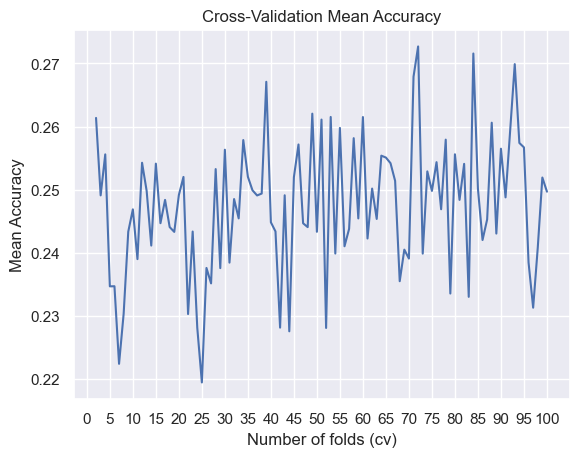

In [ ]:
# con questo codice andiamo a cercare di ottimizzare la cross-validation
# questo esperimento è stato condotto solo con 30 e non con 100 o 300 data l'impiegno computazionale
# che è stato osservato nel random forest ovvero 1 ora di computazione per fornire i risultati con 100
evaluate_classifiers_with_plot(range(2,101), [ExtraTreesClassifier], X, y, 5)

#### Conclusioni sul Extra Trees


### Metodi di boosting
 Dopo aver visto in azione un modello di ensemble che sfrutta la tecnica del Bagging proviamo a vedere qual'è il comportamento di un esemble model che sfrutti la tecnica del boosting.

Nel boosting ogni modello viene costruito in modo sequenziale in base agli errori del modello precedente.

Dei dati vengono forniti al primo classificatore, il quale effettua una prediction. Nel classificatore successivo viene dato più peso alle istanze classificate in modo sbagliate. In questo modo l’enfasi viene posta sugli errori dei classificatori precedenti.

Alla base di questo algoritmo sta il fatto di formare un certo numero di classificatori deboli che, imparando dagli errori dei precedenti e in molte iterazioni, si trasformano in un classificatore forte.

In [12]:
from sklearn.ensemble import AdaBoostClassifier

# Istanziazione di un modello ada boost
clf_AdaB = AdaBoostClassifier(n_estimators=50, random_state=42)

# usiamo la cross-val
scores_AB = cross_val_score(clf_AdaB, X, y, cv=10)
mean_accurancy_AB = scores_AB.mean()
print("Accurancy su ogni ciclo della cross-validation:\n", scores_AB)
print("Accurancy mediata su i 10 fold fatti:", mean_accurancy_AB)

Accurancy su ogni ciclo della cross-validation:
 [0.26618705 0.22302158 0.26618705 0.28776978 0.27338129 0.23913043
 0.16666667 0.2173913  0.17391304 0.27536232]
Accurancy mediata su i 10 fold fatti: 0.23890105307058698


In [13]:
# Istanziazione di un modello Ada Boost
clf_AB = AdaBoostClassifier(n_estimators=50, random_state=42)

# andiamo a visualizzare un quadro delle metriche completo
full_evaluate_multiclass(clf_AB, X, y)

Accuracy: 0.23890105307058698
Precision: 0.2387877906169302
Recall: 0.23898916967509026
F1-score: 0.23852233688621008
Precision (Macro): 0.238526774610841
Precision (Micro): 0.23898916967509026
Recall (Macro): 0.2384492175991894
Recall (Micro): 0.23898916967509026
F1-score (Macro): 0.23813376045752832
F1-score (Micro): 0.23898916967509026
F2-score (Micro): 0.23898916967509024
F2-score (Macro): 0.23823522950318282
F2-score (Weighted): 0.23871159314866366
Confusion matrix:
 [[ 73  85  84  94]
 [ 82  78  79  93]
 [ 80  76  80 119]
 [ 87  93  82 100]]


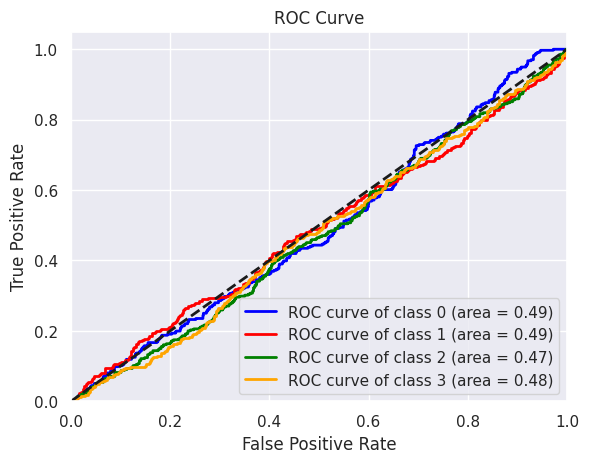

ROC AUC Score (macro): 0.4836736525835284
ROC AUC Score (micro): 0.4836736525835284


In [14]:
# Istanziazione di un modello Ada Boost
clf_AB2 =  AdaBoostClassifier(n_estimators=50, random_state=42)

# plotta la curva del roc_auc_score
evaluate_roc_auc(clf_AB2 , X, y)

In [ ]:
# proviamo adaboost sui  principali valori di folds per la cross_validation
clf_nodA =[AdaBoostClassifier]
evaluate_classifiers(values, clf_nodA, X, y)

Classifier: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
CV: 5
Mean Accuracy: 0.2267148014440433
Scores: [0.23826715 0.23465704 0.22743682 0.18050542 0.25270758]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.23029402564904605
Scores: [0.24460432 0.1942446  0.27338129 0.25899281 0.22302158 0.24637681
 0.1884058  0.20289855 0.24637681 0.22463768]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.23744740532959327
Scores: [0.1827957  0.23655914 0.31182796 0.32258065 0.2688172  0.2826087
 0.2173913  0.18478261 0.20652174 0.15217391 0.20652174 0.17391304
 0.23913043 0.27173913 0.30434783]
__________________________________________________________________________
############################################################

Classifier: <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>
CV: 2
Mean Accuracy: 0.2151636096722802
Scores: [0.21356421 0.21676301]
__________________________________________________________________________
##########################################################################
 
CV: 3
Mean Accuracy: 0.21733448523036372
Scores: [0.21212121 0.21428571 0.22559653]
__________________________________________________________________________
##########################################################################
 
CV: 4
Mean Accuracy: 0.22743249321184056
Scores: [0.23342939 0.24277457 0.19653179 0.23699422]
__________________________________________________________________________
##########################################################################
 
CV: 5
Mean Accuracy: 0.2267148014440433
Scores: [0.23826715 0.23465704 0.22743682 0.18050542 0.25270758]
__________________________________________________________________________
######################################

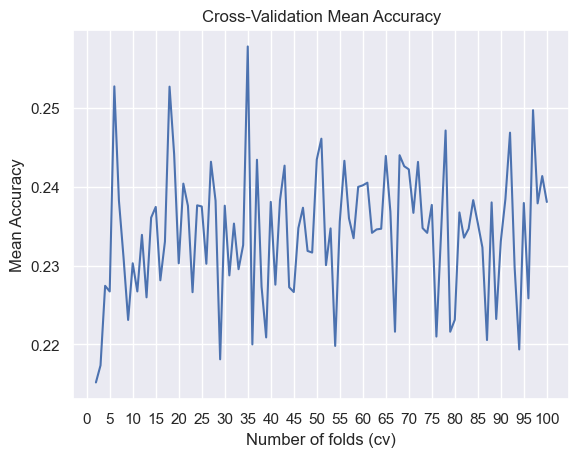

In [ ]:
# ottimizziamo il k per effettuare il fold della cross_validation
evaluate_classifiers_with_plot(range(2,101), [AdaBoostClassifier], X, y, 5)


#### Conclusioni sul Ada Boost
Questo modello di ensemble è stato meno performante dei modelli con Bagging infatti presenta oscillazioni più basse e un range di varianza inferiore ai preceddenti e come si vede dal grafico solo 2 pichi sopra il 25% di accurancy il resto tende a non superare il 24%.

In [15]:
# applichiamo un trasformer sulla feature target in quanto il modello che andremo
# ad usare necessita di tale trasformazione
def transform_column(column):
    new_column = np.where(column == 1, 0, column)
    new_column = np.where(column == 2, 1, new_column)
    new_column = np.where(column == 3, 2, new_column)
    new_column = np.where(column == 4, 3, new_column)
    return new_column

# Esempio di utilizzo
series_y_enc = df['Baselinehistological staging']
list_y_enc = series_y_enc.values
y_enc = transform_column(list_y_enc)

print("Colonna originale:", list_y_enc)
print("Nuova colonna trasformata:", y_enc)

Colonna originale: [2. 2. 4. ... 2. 3. 3.]
Nuova colonna trasformata: [1. 1. 3. ... 1. 2. 2.]


In [ ]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Istanziazione di un modello di esemble di tipo XGBoosting
clf_xgb = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# usiamo la cross-val
scores_xgb = cross_val_score(clf_xgb, X, y_enc, cv=10)
mean_accurancy_xgb = scores_xgb.mean()
print("Accurancy su ogni ciclo della cross-validation:\n", scores_xgb)
print("Accurancy mediata su i 10 fold fatti:", mean_accurancy_xgb)


Accurancy su ogni ciclo della cross-validation:
 [0.27338129 0.28057554 0.28776978 0.23741007 0.25179856 0.2173913
 0.2173913  0.17391304 0.22463768 0.22463768]
Accurancy mediata su i 10 fold fatti: 0.23889062662913146


In [18]:
# Istanziazione di un modello XGBoost
clf_XGB = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# andiamo a visualizzare un quadro delle metriche completo
full_evaluate_multiclass(clf_XGB, X, y_enc)

Accuracy: 0.23889062662913146
Precision: 0.23507264351649612
Recall: 0.23898916967509026
F1-score: 0.23633914666600492
Precision (Macro): 0.233766521039842
Precision (Micro): 0.23898916967509026
Recall (Macro): 0.23678410700842206
Recall (Micro): 0.23898916967509026
F1-score (Macro): 0.23458793670621902
F1-score (Micro): 0.23898916967509026
F2-score (Micro): 0.23898916967509024
F2-score (Macro): 0.23573984268369502
F2-score (Weighted): 0.23776171425195272
Confusion matrix:
 [[ 57  87  84 108]
 [ 82  60 100  90]
 [ 71  79 103 102]
 [ 82  77  92 111]]


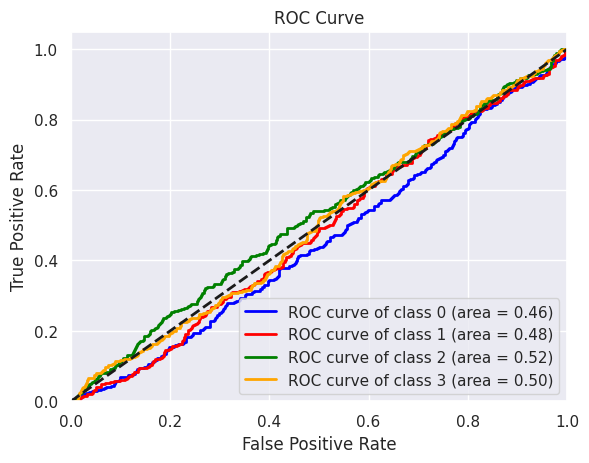

ROC AUC Score (macro): 0.4907706155870862
ROC AUC Score (micro): 0.4907706155870862


In [19]:
# Istanziazione di un modello XGBoost
clf_XGB2 =  XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# plotta la curva del roc_auc_score
evaluate_roc_auc(clf_XGB2 , X, y_enc)

In [ ]:
# proviamo XGBoost sui  principali valori di folds per la cross_validation
clf_XB =[XGBClassifier]
evaluate_classifiers(values, clf_XB, X, y_enc)

Classifier: <class 'xgboost.sklearn.XGBClassifier'>
CV: 5
Mean Accuracy: 0.23971119133574006
Scores: [0.24548736 0.27075812 0.21299639 0.20938628 0.2599278 ]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.229470336774059
Scores: [0.27338129 0.25179856 0.30935252 0.23021583 0.26618705 0.19565217
 0.17391304 0.16666667 0.23188406 0.19565217]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.24179523141654977
Scores: [0.27956989 0.24731183 0.30107527 0.29032258 0.20430108 0.29347826
 0.32608696 0.23913043 0.16304348 0.25       0.23913043 0.17391304
 0.20652174 0.18478261 0.22826087]
__________________________________________________________________________
##########################################################################
 
CV: 20

Classifier: <class 'xgboost.sklearn.XGBClassifier'>
CV: 2
Mean Accuracy: 0.24982379534402654
Scores: [0.24386724 0.25578035]
__________________________________________________________________________
##########################################################################
 
CV: 3
Mean Accuracy: 0.239711963139295
Scores: [0.23376623 0.24458874 0.24078091]
__________________________________________________________________________
##########################################################################
 
CV: 4
Mean Accuracy: 0.25342739584547985
Scores: [0.25648415 0.26011561 0.24855491 0.24855491]
__________________________________________________________________________
##########################################################################
 
CV: 5
Mean Accuracy: 0.23971119133574006
Scores: [0.24548736 0.27075812 0.21299639 0.20938628 0.2599278 ]
__________________________________________________________________________
#############################################################

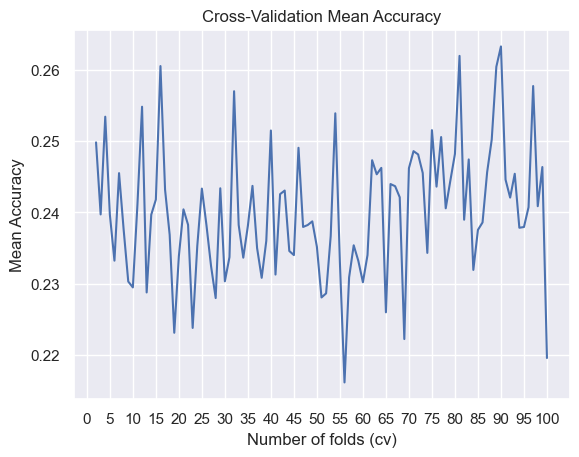

In [ ]:
# ottimizziamo il k per effettuare il fold della cross_validation
evaluate_classifiers_with_plot(range(2,101), [XGBClassifier], X, y_enc, 5)


#### Conclusioni su XGBoost
Anche per lo XGBoost le performance non cambiano di molto anche se sembra comportarsi meglio dell'ADAboost infatti riesce a toccare picchi di 26% di accurancy. Sembra che aumentando il numero di fold in particolare dopo aver superato i 17 le performance tendono a calare sotto il 24% di accurancy. Ad ogni modo restiamo sempre su modelli inefficaci per il task che ci siamo posti.

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

# istanziazione del modello classificatore Gradient Boosting
clf_GrB = GradientBoostingClassifier()

# usiamo la cross-val
scores_GrB = cross_val_score(clf_GrB, X, y, cv=10)
mean_accurancy_GrB = scores_GrB.mean()
print("Accurancy su ogni ciclo della cross-validation:\n", scores_GrB)
print("Accurancy mediata su i 10 fold fatti:", mean_accurancy_GrB)

Accurancy su ogni ciclo della cross-validation:
 [0.24460432 0.1942446  0.20863309 0.27338129 0.28776978 0.23188406
 0.18115942 0.22463768 0.23188406 0.25362319]
Accurancy mediata su i 10 fold fatti: 0.2331821499322282


In [21]:
# Istanziazione di un modello Gradient Boosting
clf_GradB = GradientBoostingClassifier()

# andiamo a visualizzare un quadro delle metriche completo
full_evaluate_multiclass(clf_GradB, X, y)

Accuracy: 0.23028881242831822
Precision: 0.22490891893970352
Recall: 0.22743682310469315
F1-score: 0.22553843910824675
Precision (Macro): 0.22410757531020276
Precision (Micro): 0.22743682310469315
Recall (Macro): 0.2258859321195986
Recall (Micro): 0.22743682310469315
F1-score (Macro): 0.22437587373905
F1-score (Micro): 0.22743682310469315
F2-score (Micro): 0.22743682310469315
F2-score (Macro): 0.22512266479753104
F2-score (Weighted): 0.2265142426918646
Confusion matrix:
 [[ 53  88  93 102]
 [ 81  70  88  93]
 [ 82  68  84 121]
 [ 84  86  84 108]]


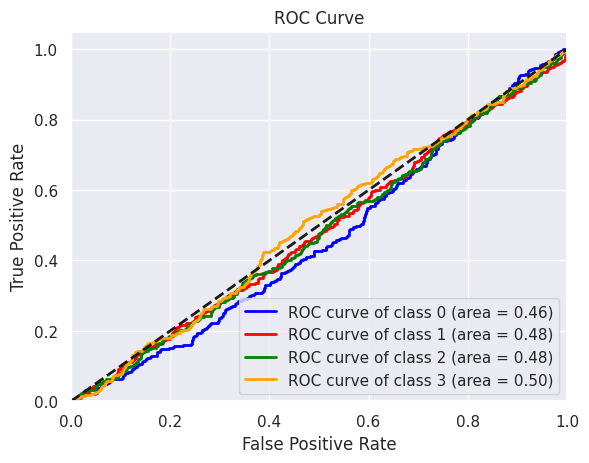

ROC AUC Score (macro): 0.4816240795111919
ROC AUC Score (micro): 0.4816240795111919


In [22]:
# Istanziazione di un modello Gradient Boosting
clf_GradB2 = GradientBoostingClassifier()

# plotta la curva del roc_auc_score
evaluate_roc_auc(clf_GradB2 , X, y_enc)

In [ ]:
# proviamo gradient boosting sui  principali valori di folds per la cross_validation
clf_GrB =[GradientBoostingClassifier]
evaluate_classifiers(values, clf_GrB, X, y)

Classifier: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV: 5
Mean Accuracy: 0.23610108303249094
Scores: [0.24548736 0.24909747 0.23104693 0.21299639 0.24187726]
__________________________________________________________________________
##########################################################################
 
CV: 10
Mean Accuracy: 0.22958502763006988
Scores: [0.20863309 0.27338129 0.20143885 0.27338129 0.21582734 0.24637681
 0.20289855 0.21014493 0.24637681 0.2173913 ]
__________________________________________________________________________
##########################################################################
 
CV: 15
Mean Accuracy: 0.21660433224248088
Scores: [0.19354839 0.25806452 0.21505376 0.2688172  0.15053763 0.23913043
 0.31521739 0.26086957 0.22826087 0.17391304 0.20652174 0.15217391
 0.22826087 0.15217391 0.20652174]
__________________________________________________________________________
###############################################################

Classifier: <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV: 2
Mean Accuracy: 0.23682010025940664
Scores: [0.24098124 0.23265896]
____________________________________________________________
############################################################
 
CV: 3
Mean Accuracy: 0.22816951667277044
Scores: [0.2034632  0.23809524 0.24295011]
____________________________________________________________
############################################################
 
CV: 4
Mean Accuracy: 0.23250903699755124
Scores: [0.2074928  0.23121387 0.25144509 0.23988439]
____________________________________________________________
############################################################
 
CV: 5
Mean Accuracy: 0.23898916967509024
Scores: [0.24548736 0.25270758 0.23104693 0.21299639 0.25270758]
____________________________________________________________
############################################################
 
CV: 6
Mean Accuracy: 0.23468536294623252
Scores: [0.2034632  0.22077922 0.25

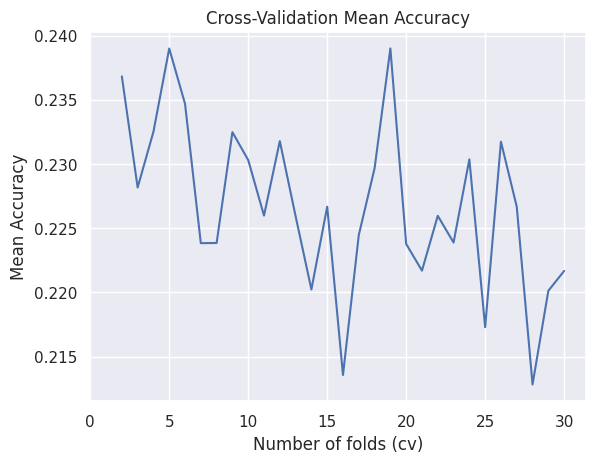

In [ ]:
# ottimizziamo gradient boosting sul parametro k per effettuare il fold della cross_validation
evaluate_classifiers_with_plot(range(2,31), clf_GrB, X, y, 5)


#### Conclusioni sul Gradient Boost
Quest'ultimo metodo di esemble basato sul boosting sembra essere il peggiore di tutti quelli utilizza anche per lui scarse performance che non superano il 24% di accurancy.